In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse.linalg

import theano
import theano.tensor as tt

import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

# Embedding a Toeplitz matrix into a Circulant Matrix

The following covariance matrix is Toeplitz.  It is stationary, and evaluated on a regularly spaced grid.

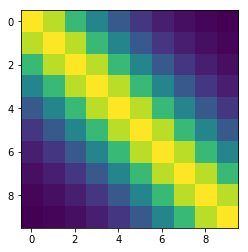

In [2]:
X = np.linspace(0,1,10)[:,None]
K = theano.function([], pm.gp.cov.Matern52(1, 0.3)(X) )()
plt.imshow(K);

In [3]:
def embed_circulant(T):
    """ Given an m x m toeplitz matrix T into an M x M circulant matrix C
        c = (t_0, t_1, ..., t_{m - 1}, 0, 0, ..., 0, 0, t_{-(m-1)}, t_{-(m-2)}, ..., t_{-1})
        M = 2^ℓ is the smallest power of 2 such that M >= 2m - 1
        M - (2m - 1) zeros
    """
    c1 = T[:, 0]
    r1 = T[0, 1:]
    m = T.shape[0]
    # shift bit length
    M = 1<<((2*m - 1) - 1).bit_length()
    return np.concatenate((c1, np.zeros(M - (2*m - 1)), r1), axis=0)

def Mv_Toeplitz(T, x):
    """ 1. Embed Toeplitz matrix into circulant
    - Given an m x m toeplitz matrix T into an M x M circulant matrix C
    - c = (t_0, t_1, ..., t_{m - 1}, 0, 0, ..., 0, 0, t_{-(m-1)}, t_{-(m-2)}, ..., t_{-1})
    - M = 2^ℓ is the smallest power of 2 such that M >= 2m - 1
    - M - (2m - 1) zeros
    """
    c1 = T[:, 0]
    r1 = T[0, 1:][::-1]
    m = T.shape[0]
    # shift bit length
    M = 1<<((2*m - 1) - 1).bit_length()
    c = np.concatenate((c1, np.zeros(M - (2*m - 1)), r1), axis=0)
    
    """ 2. Do Matrix-vector multiplication with x
    - Pad x with (M - m) zeros
    """
    xp = np.concatenate((x, np.zeros(M - m)))
    return np.real(np.fft.ifft(np.fft.fft(c) * np.fft.fft(xp))[:m])



In [4]:
x = np.random.randn(10)
b = Mv_Toeplitz(K, x)

#print(b)
print(np.dot(K, x))
print(np.real(b))


[-2.55443208 -2.84657295 -2.80467602 -2.58839028 -2.42628018 -2.46007151
 -2.63232527 -2.77130517 -2.72415625 -2.44667033]
[-2.55443208 -2.84657295 -2.80467602 -2.58839028 -2.42628018 -2.46007151
 -2.63232527 -2.77130517 -2.72415625 -2.44667033]


In [5]:

class ToeplitzLinearOperator(sp.sparse.linalg.LinearOperator):
    def __init__(self, A):
        super(ToeplitzLinearOperator, self).__init__(A.dtype, A.shape)
        self.A = A
        self.__adj = None
        self.args = (A,)

    def _matvec(self, x):
        # matrix-vector multiplication handler.
        return Mv_Toeplitz(self.A, x)    
    

In [6]:
T = ToeplitzLinearOperator(K)
print(K.shape)

(10, 10)


In [7]:
T.matvec(x)

array([-2.55443208, -2.84657295, -2.80467602, -2.58839028, -2.42628018,
       -2.46007151, -2.63232527, -2.77130517, -2.72415625, -2.44667033])

In [36]:
n = 120
X = np.linspace(0,1,n)[:,None]
b = 1e-3 * np.random.randn(n)
K = theano.function([], pm.gp.cov.Matern52(1, 0.3)(X) + 1e-8 * tt.eye(n) )()
T = ToeplitzLinearOperator(K)

#%timeit np.dot(K, b)
#%timeit Mv_Toeplitz(K, b)

M = sp.linalg.solve(K, np.eye(n))

%timeit sp.sparse.linalg.cg(T, b, M=M)
%timeit np.linalg.solve(K, b)
#print(np.dot(sp.sparse.linalg.cg(T, b, M=M)[0], b))
#print(np.dot(np.linalg.solve(K, b), b))

1000 loops, best of 3: 400 µs per loop
1000 loops, best of 3: 421 µs per loop


In [20]:
sp.linalg.solve(K, np.eye(n))

array([[  1.84702128e+10,  -6.37506742e+10,   8.44564175e+10, ...,
         -5.61183889e+04,  -4.96936987e+03,  -2.69948555e+03],
       [ -6.37508991e+10,   2.38508840e+11,  -3.55255827e+11, ...,
          4.37743878e+05,  -7.09479061e+04,   3.76798488e+04],
       [  8.44578101e+10,  -3.55260109e+11,   6.24697436e+11, ...,
         -1.86787144e+06,   6.76312102e+05,  -2.16622525e+05],
       ..., 
       [ -6.95947210e+03,   2.14779492e+05,  -1.43504371e+06, ...,
          6.29005487e+11,  -3.57519741e+11,   8.49651331e+10],
       [  1.37718709e+04,  -1.66671755e+05,   9.13732583e+05, ...,
         -3.57502212e+11,   2.39688468e+11,  -6.40158327e+10],
       [ -4.42168964e+03,   4.34203965e+04,  -2.21744088e+05, ...,
          8.49659476e+10,  -6.40185836e+10,   1.85303757e+10]])